# Importazione librerie e visualizzazione Dataset

In [ ]:
import pandas as pd
import networkx as nx
from itertools import combinations
import matplotlib.pyplot as plt

In [ ]:
#Lettura del dataset:
df_trump = pd.read_csv("/kaggle/input/us-election-2020-tweets/hashtag_donaldtrump.csv",lineterminator='\n')
df_biden = pd.read_csv("/kaggle/input/us-election-2020-tweets/hashtag_joebiden.csv",lineterminator='\n')

In [ ]:
print(f"Tweet with Trump hashtag: {len(df_trump)}")
print(f"Tweet with Biden hashtag: {len(df_biden)}")

In [ ]:
#Dataframe unito (eliminati i duplicati)
df_duplicated = pd.concat([df_trump,df_biden])
df = df_duplicated.drop_duplicates(subset="tweet")

print(f"Total tweets: {len(df_duplicated)}")
print(f"Total tweets: {len(df)}")

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
#Numero di utenti totali (potenziali nodi)
print(df["user_id"].value_counts())

In [155]:
from collections import Counter
import re

def extract_hashtags(tweet):
    return re.findall(r'#\w+', tweet.lower())

df['hashtags'] = df['tweet'].apply(extract_hashtags)

all_hashtags = [hashtag for hashtags in df['hashtags'] for hashtag in hashtags]

hashtag_counts = Counter(all_hashtags)

sorted_hashtag_counts = hashtag_counts.most_common()

# Stampare la classifica degli hashtag
print("Classifica degli hashtag più usati:")
for hashtag, count in sorted_hashtag_counts[:50]:
    print(f"{hashtag}: {count}")

/tmp/ipykernel_34/2497207750.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hashtags'] = df['tweet'].apply(extract_hashtags)


Classifica degli hashtag più usati:
#trump: 863347
#biden: 500781
#joebiden: 295275
#election2020: 139924
#donaldtrump: 132085
#elections2020: 77590
#bidenharris2020: 69976
#trump2020: 66393
#vote: 58299
#electionday: 48413
#usa: 45016
#maga: 42982
#covid19: 38383
#kamalaharris: 37605
#biden2020: 29940
#electionnight: 27977
#uselection2020: 27542
#bidenharris: 26712
#america: 25089
#elecciones2020: 22864
#electionresults2020: 22861
#trumpmeltdown: 20640
#usaelections2020: 19958
#bidenharis2020: 19367
#debates2020: 19012
#democrats: 18316
#vote2020: 17682
#gop: 17331
#election: 16943
#coronavirus: 16796
#trumpvsbiden: 16670
#election2020results: 16606
#elections: 16043
#usaelection2020: 15554
#maga2020: 14578
#covid: 14239
#pennsylvania: 14156
#hunterbiden: 14129
#uselections2020: 14014
#2020election: 13844
#uselection: 13477
#cnn: 13441
#trumpislosing: 12883
#obama: 12785
#potus: 12186
#byebyetrump: 12113
#joebiden2020: 12076
#joebidenkamalaharris2020: 12041
#votehimout: 11950
#foxnews

Osservazioni:
- Informazioni temporali che vanno dal 15 ottobre 2020 al 8 novembre 2020.
- 481.000 potenziali nodi (filtraggio sulla base di like/retweet?)
- Tweet scritti in diverse lingue (concentrarsi solo su quelli in inglese?)
- Diversi valori mancanti nelle aree geografiche

# Preprocessing (filtraggio tweet/utenti)

Probabilmente il primo filtraggio che occorre fare è quello sulla lingua. Potrebbe essere meglio considerare solo i tweet in inglese (?)

In [ ]:
#Filtraggio sulla base dei like
df_like_5 = df[df["likes"]>=5]
df_like_10 = df[df["likes"]>=10]
df_like_20 = df[df["likes"]>=20]
df_like_50 = df[df["likes"]>=50]

print(f"Total tweets: {len(df_like_5)}")
print(f"Total tweets: {len(df_like_10)}")
print(f"Total tweets: {len(df_like_20)}")
print(f"Total tweets: {len(df_like_50)}")
print(df_like_50["user_id"].value_counts())

In [ ]:
#Filtraggio sulla base dei retweet
df_retweet_5 = df[df["retweet_count"]>=5]
df_retweet_10 = df[df["retweet_count"]>=10]
df_retweet_20 = df[df["retweet_count"]>=20]
df_retweet_50 = df[df["retweet_count"]>=50]

print(f"Total tweets: {len(df_retweet_5)}")
print(f"Total tweets: {len(df_retweet_10)}")
print(f"Total tweets: {len(df_retweet_20)}")
print(f"Total tweets: {len(df_retweet_50)}")
print(df_retweet_50["user_id"].value_counts())

In [ ]:
#FILTRAGGIO BASATO SU paese=United states
df_country= df[df["country"]=="United States of America"]
print(f"Total tweets: {len(df_country)}")

print(df_country["user_id"].value_counts())
df_country.tail()

In [ ]:
#FILTRAGGIO BASATO SU stato!=null
df_state= df_country[pd.notnull(df_country['state'])]
print(f"Total tweets: {len(df_country)}")

print(df_state["user_id"].value_counts())

Osservazione: sono pochi gli utenti che risiedono negli stati uniti e che hanno state==null

# Costruisco la rete con le menzioni

* Obiettivo: costruire una rete che tenga conto delle menzioni che provengono da utenti USA con più di 15.000 followers (potenzialmente i più influenti).
* Obiettivo: costruire una rete che tenga conto delle menzioni che provengono da utenti USA con meno di 1.000 followers, studiamo comportamento tipico di persone meno famose.
* Misurazione delle principali misure di centralità: in_degree, betweness, closeness.
* Si potrebbe verificare con l'out_degree se sono presenti spam_farm (to do)
* Degree distribution (to do)
* Page rank (to do)

In [ ]:
popular = False #se true, considero rete con >15.000 followers, se false considero rete con <1.000 followers

#FILTRAGGIO BASATO SU stato= United states e sul numero di follower, voglio capire se ci sono
#utenti importanti o se ho completamente rimosso profili di informazione
if popular:
    df_country_e_follower= df_country[df_country["user_followers_count"]>=15000]
else:
    df_country_e_follower= df_country[df_country["user_followers_count"]<1000]
print(f"Total tweets: {len(df_country_e_follower)}")
print(df_country_e_follower["user_id"].value_counts())
df_country_e_follower.tail()


In [ ]:
#FILTRAGGIO BASATO SU MENZIONI+country+followers
def contains_mentions(tweet):
    return '@' in tweet

df_with_mentions = df_country_e_follower[df_country_e_follower['tweet'].apply(contains_mentions)]

print(f"Total tweets: {len(df_with_mentions)}")

df_with_mentions.head()
print(df_with_mentions["user_id"].value_counts())
#PS MI SONO ACCORTA CHE NON è BANALE REALIZZARE UN ARCO SE C'è UNA MENZIONE
#DEVI RISALIRE AL USER ID DAL NOME 
#MA QUELL'UTENTE POTREBBE NON ESISTERE NEI DATI SE NON HA PUBBLICATO NIENTE (ci interessa davvero se abbia pubblicato qualcosa?)

In [ ]:
import re
# Initialize a directed graph
G = nx.DiGraph()

# Function to extract mentioned users from a tweet
def extract_mentions(tweet):
    return re.findall(r"@(\w+)", tweet)

# Add nodes and edges based on mentions
for index, row in df_with_mentions.iterrows():
    user_screen_name = row['user_screen_name'] #nome dell'utente
    mentions = extract_mentions(row['tweet']) #menzioni dell'utente verso altri utenti
    
    # Add the user as a node
    if not G.has_node(user_screen_name): #se utente non presente, lo aggiungo alla rete
        G.add_node(user_screen_name)
    
    # Add edges from the user to each mentioned user if the mentioned user is already a node
    for mention in mentions:
        if not G.has_node(mention): #se il nodo menzionato non è presente, lo aggiungo alla rete
            G.add_node(mention)
        if mention!=user_screen_name: #rimuovo i selfloop (automenzioni)
            G.add_edge(user_screen_name, mention)
        

# Display the number of nodes and edges
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

La rete è troppo grande, è il caso di applicare ulteriori filtraggi? (Per esempio, considerare utenti che hanno almeno un certo numero di menzioni), controllo con un parametro "min_number_of_mentions", elimino tutti i nodi che hanno un in_degree inferiore a una certa soglia.

In [ ]:
min_number_of_mentions = 1

in_degrees = dict(G.in_degree())
nodes_to_remove = [node for node, degree in in_degrees.items() if degree < min_number_of_mentions]

# Rimuovere i nodi dal grafo
G.remove_nodes_from(nodes_to_remove)

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Non va bene questo approccio, elimino troppi archi all'interno della rete perdendo informazione.

In [ ]:
import matplotlib.pyplot as plt

# Plot the network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.1)
nx.draw(G, pos, with_labels=True, node_size=20, node_color='blue', font_size=10, font_color='white')
plt.title(' Network utenti menzioni provenienti da tweet di utenti USA con >15000 follower')
plt.show()

Per ora la rete è orientata, quindi c'è un arco da n1 a n2 se n1 menziona n2.

In [ ]:
# Betweenness Centrality
"""
betweenness_centrality = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame(list(betweenness_centrality.items()), columns=['user_screen_name', 'betweenness_centrality'])
betweenness_df = betweenness_df.sort_values(by='betweenness_centrality', ascending=False)
print(betweenness_df.head())
"""

betweenness_centrality = nx.betweenness_centrality(G)

# Ordiniamo i nodi in base ai valori di betweenness centrality in ordine decrescente
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

# Stampiamo i nodi con i valori più alti di betweenness centrality
for node, centrality in sorted_betweenness[:10]: #stampo solo i migliori 10
    print(f'Nodo: {node}, Betweenness Centrality: {centrality:.6f}')

Betweness centrality molto bassa

In [ ]:
# Degree Centrality
"""
degree_centrality = nx.degree_centrality(G)
degree_df = pd.DataFrame(list(degree_centrality.items()), columns=['user_screen_name', 'degree_centrality'])
degree_df = degree_df.sort_values(by='degree_centrality', ascending=False)
print(degree_df.head())
"""

degree_centrality = nx.in_degree_centrality(G)

# Ordiniamo i nodi in base ai valori di degree centrality in ordine decrescente
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Stampiamo i nodi con i valori più alti di degree centrality
for node, centrality in sorted_degree[:10]: #stampo solo i migliori 10
    print(f'Nodo: {node}, Degree Centrality: {centrality:.6f}')

In [ ]:
#Closeness 
"""
closeness_centrality = nx.closeness_centrality(G)
closeness_df = pd.DataFrame(list(closeness_centrality.items()), columns=['user_screen_name', 'closeness_centrality'])
closeness_df = closeness_df.sort_values(by='closeness_centrality', ascending=False)
print(closeness_df.head())
"""

closeness_centrality = nx.closeness_centrality(G)

# Ordiniamo i nodi in base ai valori di degree centrality in ordine decrescente
sorted_degree = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

# Stampiamo i nodi con i valori più alti di degree centrality
for node, centrality in sorted_degree[:10]: #stampo solo i migliori 10
    print(f'Nodo: {node}, Closeness Centrality: {centrality:.6f}')

Rimuovendo i nodi isolati, la rete diventa più densa e le misure di centralità potrebbero aumentare per alcuni nodi. Questo accade perché la centralità è spesso una misura relativa e viene calcolata rispetto all'intera rete. Eliminare i nodi che non hanno connessioni (e quindi non contribuiscono alla rete) può far sì che i nodi rimanenti abbiano un impatto maggiore.

In [ ]:
# Rimuovere i nodi isolati
isolated_nodes = list(nx.isolates(G))
G.remove_nodes_from(isolated_nodes)

# Display the number of nodes and edges
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

#Vengono rimossi pochi nodi (una ventina, probabilmente sono nodi che si automenzionano e basta)

In [ ]:
"""
# Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame(list(betweenness_centrality.items()), columns=['user_screen_name', 'betweenness_centrality'])
betweenness_df = betweenness_df.sort_values(by='betweenness_centrality', ascending=False)
print(betweenness_df.head())
#Closeness 
closeness_centrality = nx.closeness_centrality(G)
closeness_df = pd.DataFrame(list(closeness_centrality.items()), columns=['user_screen_name', 'closeness_centrality'])
closeness_df = closeness_df.sort_values(by='closeness_centrality', ascending=False)
print(closeness_df.head())
# Degree Centrality
degree_centrality = nx.degree_centrality(G)
degree_df = pd.DataFrame(list(degree_centrality.items()), columns=['user_screen_name', 'degree_centrality'])
degree_df = degree_df.sort_values(by='degree_centrality', ascending=False)
print(degree_df.head())
"""

In [ ]:
import matplotlib.pyplot as plt

# Plot the network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.1)

#Nodi piu grandi sono associati a degree centrality maggiore
node_size = [v * 10000 for v in degree_centrality.values()]


nx.draw(G, pos, with_labels=True, node_size=node_size, node_color='blue', font_size=10, font_color='black', edge_color='gray')
plt.title(' Network utenti USA con >15000 follower')
plt.show()

# Costruisco la rete geografica
* è una rete non orientata
* Considero solo gli utenti negli USA e che hanno stato!=null
* Inserisco un arco tra gli utenti dello stesso stato
* Classifico ogni utente in pro-trump / pro-biden e lo coloro di rosso / blu
* Creazione dei sottografi: Utilizziamo G.subgraph(nodes) per creare sottografi per ciascuno stato, selezionando i nodi che appartengono a quel particolare stato.
* **Analisi degli stati con più sostenitori di Trump:** Conta il numero di nodi con preferenza politica "Trump" per ogni stato e stampa i risultati ordinati per numero decrescente.
* **Fornire una predizione dell'esito delle elezioni e confrontarlo con ground trouth**




In [ ]:
pip install transformers

In [ ]:
from transformers import pipeline
import torch

device = 0 if torch.cuda.is_available() else -1

# Caricare il modello di sentiment analysis
classifier = pipeline("text-classification", model="DT12the/distilbert-sentiment-analysis", device=device)

In [ ]:
# Definire una funzione per classificare i tweet
#questa è approssimativa, perche se c'è un tweet con due tag?
#inoltre devo considerare una lista di tag con tutte le varianti di tag 
def classify_tweet(tweet):
    result = classifier(tweet)[0]
    if 'Trump' in tweet:
        return 'pro-Trump' if result['label'] == 'LABEL_0' else 'anti-Trump'
    elif 'Biden' in tweet:
        return 'pro-Biden' if result['label'] == 'LABEL_0' else 'anti-Biden'
    else:
        return 'neutral' 

**Costruzione rete**

In [ ]:
print(df.iloc[5]['tweet'])

classify_tweet(df.iloc[5]['tweet'])

In [ ]:
df_country_e_follower= df_country[df_country["user_followers_count"]<1000] #prendo gli utenti meno "popolari"
print(f"Total tweets: {len(df_country_e_follower)}")
print(df_country_e_follower["user_id"].value_counts())

#Concatenazione dei tweet per l'utente
grouped_df = df_country_e_follower.groupby('user_id')['tweet'].apply(lambda tweets: ' '.join(tweets)).reset_index()
print(f"Total tweets after concate: {len(grouped_df)}")

#Drop colonna tweet dal primo dataframe
df_dropped = df_country_e_follower.drop(columns=['tweet'])

#Faccio la join per avere tutti i tweet insieme
df_conc = pd.merge(df_dropped, grouped_df, on='user_id', how='inner')
print(df_conc["user_id"].value_counts())
df_conc.head()

In [ ]:
G_geo = nx.Graph() #NN orient

# Aggiungi nodi (utenti degli USA)
for index, row in df_conc.iterrows(): 
    if  pd.notnull(row['state']):
        political_preference=classify_tweet(row['tweet'])
        #print(political_preference)
        G_geo.add_node(row['user_screen_name'], state=row['state'],
                   political_preference=political_preference)

In [ ]:
#aggiunta archi
for u in G_geo.nodes():
    for v in G_geo.nodes():
        if u != v and G_geo.nodes[u]['state'] == G_geo.nodes[v]['state']:
            G_geo.add_edge(u, v, relationship='same_state')

In [ ]:
# Display the number of nodes and edges
print(f"Number of nodes: {G_geo.number_of_nodes()}")
print(f"Number of edges: {G_geo.number_of_edges()}")

In [ ]:
# Colorazione dei nodi in base alla political_preference
node_colors = []
for node in G_geo.nodes():
    if G_geo.nodes[node]['political_preference'] == 'pro-Biden' or G_geo.nodes[node]['political_preference'] == 'anti-Trump':
        node_colors.append('blue')  # Colore blu per i sostenitori di Biden
    elif G_geo.nodes[node]['political_preference'] == 'pro-Trump'or G_geo.nodes[node]['political_preference'] == 'anti-Biden':
        node_colors.append('red')   # Colore rosso per i sostenitori di Trump
    else:
        node_colors.append('gray')  # Colore grigio per i neutrali
        
# Disegna il grafo con i nodi colorati
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_geo, k=0.1)
nx.draw(G_geo, pos, with_labels=True, node_color=node_colors, node_size=20, font_size=0, font_color='black', edge_color='gray')


In [ ]:
"""
import matplotlib.cm as cm
import numpy as np

# Creazione dei sottografi per ciascuno stato
state_graphs = {}
for state in set(nx.get_node_attributes(G_geo, 'state').values()):
    state_graphs[state] = G_geo.subgraph([n for n, d in G_geo.nodes(data=True) if d['state'] == state])

# Disegna la rete con i cluster stati
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_geo, k=0.1)

# Genera una lista di colori
colors = cm.rainbow(np.linspace(0, 1, len(state_graphs)))

# Disegna i sottografi per ciascuno stato
for color, (state, subgraph) in zip(colors, state_graphs.items()):
    nx.draw_networkx_nodes(subgraph, pos, node_size=20, label=state, node_color=[color] * subgraph.number_of_nodes())
    nx.draw_networkx_edges(subgraph, pos, alpha=0.3)
    

plt.title('Rete sociale con cluster per stati')
plt.legend(state_graphs.keys())
plt.show()
"""

# Costruisco la rete di similarità con gli hashtag

Si pone il seguente problema: potrebbe non essere la scelta giusta andare a escludere utenti per numero di followers. Da un lato potremmo escludere il comportamento tipico degli utenti meno popolari, che sono anche quelli più numerosi (le persone comuni, che poi di fatto vanno a votare), dall'altro potremmo escludere il ruolo di utenti più popolari in grado di influenzare maggiormente gli altri utenti. Potremmo pensare di effettuare un campionamento casuale dei nodi per ridurre la dimensione della rete? Oppure dovremmo pensare al filtraggio sotto altri metodi (numero di like o retweet?). Potremmo fare anche un campionamento che si basa sulla degree distribution. Probabilmente la cosa migliore è andare a fare un campionamento casuale direttamente sul dataset.

In [156]:
print(df_country["user_screen_name"].value_counts())


"""
df_country_e_follower= df_country[df_country["user_followers_count"]>10000] 
print(f"Total tweets: {len(df_country_e_follower)}")
print(df_country_e_follower["user_id"].value_counts())
"""

#Concatenazione dei tweet per l'utente
grouped_df = df_country.groupby('user_screen_name')['tweet'].apply(lambda tweets: ' '.join(tweets)).reset_index()
print(f"Total tweets after concate: {len(grouped_df)}")

#Drop colonna tweet dal primo dataframe
df_dropped = df_country.drop(columns=['tweet']) 

#Faccio la join per avere tutti i tweet insieme
df_conc = pd.merge(df_dropped, grouped_df, on='user_screen_name', how='inner')
print(len(df_conc))
print(df_conc["user_screen_name"].value_counts())
df_conc.head()

grouped_conc = df_country.groupby('user_screen_name')['tweet'].apply(lambda tweets: ' '.join(tweets)).reset_index()
print(grouped_conc["user_screen_name"].value_counts())

user_screen_name
steveziegenbus2    1259
JournalistJG       1059
mcleod              980
lookforsun          856
Starbright489       785
                   ... 
TxHellraiser76        1
tee_omm               1
LCarpen97702802       1
kylejust1ce           1
joebessemer           1
Name: count, Length: 76279, dtype: int64
Total tweets after concate: 76279
297754
user_screen_name
steveziegenbus2    1259
JournalistJG       1059
mcleod              980
lookforsun          856
Starbright489       785
                   ... 
TxHellraiser76        1
tee_omm               1
LCarpen97702802       1
kylejust1ce           1
joebessemer           1
Name: count, Length: 76279, dtype: int64
user_screen_name
zzz_ooo_eee        1
000HMY             1
001Newway          1
007442008OB        1
007__NIL           1
                  ..
0amaam             1
0bzerve            1
0ch0a21            1
0fficiallyJoee_    1
0hGood4U           1
Name: count, Length: 76279, dtype: int64


In [157]:
# Effettuo un campionamento casuale del dataset (gli utenti sono troppi e non riusciremmo a costruire la rete)

df_sampled = grouped_conc.sample(frac=0.1, random_state=42)
print(df_sampled["user_screen_name"].value_counts())

# Idea di altro campionamento: 
# stimo i degree in modo parallelo (calcolo similarità dei primi 100 utenti con tutti gli altri)
# campiono seguendo la stima della distribuzione

user_screen_name
ericbgriffin       1
oelumeze           1
mclozano1111       1
katinaphoto        1
OakFoSho           1
                  ..
EntBibbit          1
biasedmedia101     1
Steffonned         1
CarolineCorvino    1
MissJenn22673      1
Name: count, Length: 7628, dtype: int64


Osservazione: bisognerebbe forse creare dei macro-hashtag. Hashtag simili dovrebbero appartenere a un unico hashtag più generale. Per ora costruiamo la rete senza tener conto di questo.

In [158]:
# Funzione per estrarre gli hashtag da un tweet
def extract_hashtags(tweet):
    return re.findall(r'#\w+', tweet.lower())

# Aggiungere una colonna con gli hashtag estratti
df_final = df_sampled.copy()
df_final['hashtags'] = df_sampled['tweet'].apply(extract_hashtags)

# Aggregare gli hashtag per ogni utente
user_hashtags = df_final.groupby('user_screen_name')['hashtags'].apply(lambda x: set().union(*x)).reset_index()

print(len(user_hashtags))
print(user_hashtags["user_screen_name"].value_counts())

7628
user_screen_name
zzxyxy            1
0nlyInFlorida     1
0skar_Out         1
11lava1           1
12_12             1
                 ..
1LineDrawing      1
1NFL_Insiders     1
1Realnatalee      1
1TruePatriot1     1
1adyandtheramp    1
Name: count, Length: 7628, dtype: int64


In [159]:
user_hashtags.head()

,user_screen_name,hashtags
0,0nlyInFlorida,"{#floridaman, #biden, #florida, #miami, #trump}"
1,0skar_Out,{#trump}
2,11lava1,"{#bidencorruption, #trump, #biden}"
3,12_12,"{#trumpvirus, #trumptrainmeltdown, #bidenharis..."
4,1440dallasga,{#joebiden}


In [160]:
Threshold = 0.5
df_final = user_hashtags

# Funzione per calcolare la similarità di Jaccard
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    if union == 0:
        return 0
    return intersection / union

# Calcolare la similarità di Jaccard tra ogni coppia di utenti
edges = []
for (user1, hashtags1), (user2, hashtags2) in combinations(df_final.itertuples(index=False), 2):
    similarity = jaccard_similarity(hashtags1, hashtags2)
    if similarity > Threshold:  # Aggiungere solo archi con similarità positiva
        edges.append((user1, user2, similarity))

# Creare un grafo vuoto
G = nx.Graph()

# Aggiungere nodi (utenti)
for user in df_final['user_screen_name']: 
    G.add_node(user)

# Aggiungere archi con pesi (similarità di Jaccard)
for user1, user2, weight in edges:
    G.add_edge(user1, user2, weight=weight)
    

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 7628
Number of edges: 352264


In [ ]:
# Disegnare il grafo (non si capisce niente, troppi nodi dentro la rete)
pos = nx.spring_layout(G)  # Posizionamento dei nodi
weights = nx.get_edge_attributes(G, 'weight').values()

nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=5, font_size=5, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f'{d["weight"]:.2f}' for u, v, d in G.edges(data=True)}, font_color='red')
nx.draw_networkx_edges(G, pos, width=list(weights))

plt.show()

In [ ]:
# Plot della degree distribution

# Calcolare i gradi dei nodi
degrees = [degree for node, degree in G.degree()]

# Calcolare la distribuzione dei gradi
degree_count = Counter(degrees)
deg, cnt = zip(*degree_count.items())

# Fare il plot della distribuzione dei gradi
plt.figure(figsize=(8, 6))
plt.bar(deg, cnt, width=10, color='b')

plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")

plt.show()

Osserviamo la presenza di una power law, ma probabilmente ci sono 3 componenti giganti connesse! Provo a estrarre utenti che fanno parte di quelle componenti e vedo i loro hashtags per confermare la presenza di componenti giganti.

In [ ]:
print(degree_count)

In [ ]:
#Prendiamo gli utenti che hanno degree 998.

desired_degree = 767 #950, #767, #998

# Filtrare i nodi che hanno il grado specificato
nodes_with_desired_degree = [node for node, degree in degree_dict.items() if degree == desired_degree]

df_giant = df_final[df_final["user_screen_name"].isin(nodes_with_desired_degree)]
# Stampare i nodi con il grado desiderato
print(f"Nodi con grado {df_giant}:")
print(df_giant)

Come sospettato, le componenti connesse sono legate agli hashtag #trump, #biden, #joebiden

In [ ]:
# Plot della weighted degree

# Calcolare il weighted degree dei nodi
weighted_degrees = dict(G.degree(weight='weight'))

# Calcolare la distribuzione del weighted degree
weighted_degree_count = Counter(weighted_degrees.values())
deg, cnt = zip(*weighted_degree_count.items())

# Fare il plot della distribuzione del weighted degree
plt.figure(figsize=(8, 6))
plt.bar(deg, cnt, width=10, color='b')

plt.title("Weighted Degree Distribution")
plt.xlabel("Weighted Degree")
plt.ylabel("Frequency")

plt.show()

Si potrebbe effettuare un campionamento dei nodi tenendo conto della degree distribution dei nodi

In [ ]:
# Definire la funzione di campionamento basato sui gradi
"""
def degree_based_sampling(graph, sample_size):
    # Calcolare i gradi dei nodi
    degrees = dict(graph.degree())
    nodes, degree_values = zip(*degrees.items())
    
    # Convertire i gradi in probabilità (più alto il grado, maggiore la probabilità di essere selezionato)
    total_degree = sum(degree_values)
    probabilities = [degree / total_degree for degree in degree_values]
    
    # Campionare i nodi in base alle probabilità
    sampled_nodes = np.random.choice(nodes, size=sample_size, replace=False, p=probabilities)
    
    # Restituire il sottografo campionato
    return graph.subgraph(sampled_nodes)

# Campionare il 20% dei nodi basato sui gradi
sample_size = int(len(G.nodes) * 0.2)
G_sampled = degree_based_sampling(G, sample_size)

# Calcolare la distribuzione dei gradi nel grafo campionato
sampled_degrees = [degree for node, degree in G_sampled.degree()]
sampled_degree_count = Counter(sampled_degrees)
sampled_deg, sampled_cnt = zip(*sampled_degree_count.items())

# Fare il plot della distribuzione dei gradi nel grafo campionato
plt.figure(figsize=(8, 6))
plt.bar(sampled_deg, sampled_cnt, width=0.80, color='b')

plt.title("Degree Distribution in Sampled Graph")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

# Fare il plot della distribuzione dei gradi nel grafo originale per confronto
original_degrees = [degree for node, degree in G.degree()]
original_degree_count = Counter(original_degrees)
orig_deg, orig_cnt = zip(*original_degree_count.items())

plt.figure(figsize=(8, 6))
plt.bar(orig_deg, orig_cnt, width=0.80, color='r')

plt.title("Degree Distribution in Original Graph")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()
"""

Analisi con le misure di centralità

In [ ]:
# Degree Centrality
"""
degree_centrality = nx.degree_centrality(G)
degree_df = pd.DataFrame(list(degree_centrality.items()), columns=['user_screen_name', 'degree_centrality'])
degree_df = degree_df.sort_values(by='degree_centrality', ascending=False)
print(degree_df.head())
"""

degree_centrality = nx.degree_centrality(G)

# Ordiniamo i nodi in base ai valori di degree centrality in ordine decrescente
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Stampiamo i nodi con i valori più alti di degree centrality
for node, centrality in sorted_degree[:10]: #stampo solo i migliori 10
    print(f'Nodo: {node}, Degree Centrality: {centrality:.6f}')

In [ ]:
#Closeness 
"""
closeness_centrality = nx.closeness_centrality(G)
closeness_df = pd.DataFrame(list(closeness_centrality.items()), columns=['user_screen_name', 'closeness_centrality'])
closeness_df = closeness_df.sort_values(by='closeness_centrality', ascending=False)
print(closeness_df.head())
"""

closeness_centrality = nx.closeness_centrality(G)

# Ordiniamo i nodi in base ai valori di degree centrality in ordine decrescente
sorted_degree = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

# Stampiamo i nodi con i valori più alti di degree centrality
for node, centrality in sorted_degree[:10]: #stampo solo i migliori 10
    print(f'Nodo: {node}, Closeness Centrality: {centrality:.6f}')

### Community detection con la rete tra gli hashtags

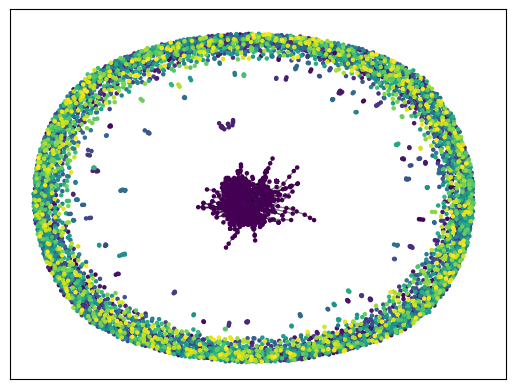

In [161]:
import community as community_louvain

# Eseguire la community detection usando l'algoritmo di Louvain
partition = community_louvain.best_partition(G)

# Disegnare il grafo con le comunità
pos = nx.spring_layout(G)
cmap = plt.get_cmap('viridis')
nx.draw_networkx_nodes(G, pos, node_size=5, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [ ]:
communities = {}
for node, community in partition.items():
    if community not in communities:
        communities[community] = []
    communities[community].append(node)

for community, nodes in communities.items():
    print(f"Community {community}:")
    print(", ".join(nodes))

### Creazione macro-hashtag

Estraggo tutti gli hashtags:

In [151]:
all_hashtags = [hashtag for hashtags in user_hashtags['hashtags'] for hashtag in hashtags]

hashtag_counts = Counter(all_hashtags)

#rimuovo tutti gli hashtags che sono stati usati meno di 5 volte.
filtered_hashtags = [hashtag for hashtag, count in hashtag_counts.items() if count >= 30]
"""
sorted_hashtag_counts = filtered_hashtag_counts.most_common()

# Stampare la classifica degli hashtag
print("Classifica degli hashtag più usati:")
for hashtag, count in sorted_hashtag_counts[:50]:
    print(f"{hashtag}: {count}")
"""
print(f"Number of hashtags:{len(hashtag_counts)}")
print(f"Number of hashtags:{len(filtered_hashtags)}")

Number of hashtags:21004
Number of hashtags:418


Usiamo LLAMA3 per individuare quelli che possono essere dei macrohashtag

Problema, l'output viene sempre troncato perché è troppo lungo.

In [152]:
import subprocess
import threading

!pip install langchain-community
!pip install langchain-core

#istallazione di ollama
!curl -fsSL https://ollama.com/install.sh | sh
    
#Avvio del server locale di Ollama
t = threading.Thread(target=lambda: subprocess.run(["ollama", "serve"]),daemon=True)
t.start()

!ollama pull llama3

t2 = threading.Thread(target=lambda: subprocess.run(["ollama", "run", "llama3"]),daemon=True)
t2.start()

>>> Downloading ollama...
######################################################################## 100.0%
>>> Installing ollama to /usr/local/bin...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> NVIDIA GPU installed.
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


Error: listen tcp 127.0.0.1:11434: bind: address already in use


[GIN] 2024/07/14 - 09:22:52 | 200 |       37.02µs |       127.0.0.1 | HEAD     "/"
pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ [GIN] 2024/07/14 - 09:22:52 | 200 |  493.449253ms |       127.0.0.1 | POST     "/api/pull"
pulling manifest 
pulling 6a0746a1ec1a... 100% ▕████████████████▏ 4.7 GB                         
pulling 4fa551d4f938... 100% ▕████████████████▏  12 KB                         
pulling 8ab4849b038c... 100% ▕████████████████▏  254 B                         
pulling 577073ffcc6c... 100% ▕████████████████▏  110 B                         
pulling 3f8eb4da87fa... 100% ▕████████████████▏  485 B                         
verifying sha256 digest 
writing manifest 
removing any unused layers 
success 


In [153]:
from langchain_community.llms import Ollama
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

prompt = "You are an hashtag evaluator. Your role is to analyze all the hashtags and group them in macro-categories of hashtags, which are the most general."

llm = Ollama(
    model="llama3"
)  # assuming you have Ollama installed and have llama3 model pulled with `ollama pull llama3 `

template = ChatPromptTemplate.from_messages([
    ("system", prompt),
    ("user", "{input}"),
])

output_parser = StrOutputParser()


def hashtags_to_llama(hashtags):   
    #chain = template | llm | output_parser
    
    #response = chain.invoke({"input": "Tweet 1:" +tweet1+ ". Tweet 2:" +tweet2})
    response = llm.invoke(prompt + "Hashtags:" + hashtags)
    
    return response

In [154]:
import json

# Specifica il nome del file JSON
filename = '/kaggle/working/hashtags.json'
hashtags_list = ""


for hashtag in hashtag_counts:
    hashtags_list = hashtags_list + " " + hashtag 
#print(hashtags_list)
    
resp = hashtags_to_llama(hashtags_list)
print(resp)
    
# Scrivi i dati nel file JSON
with open(filename, 'w') as file:
    json.dump(resp, file)

[GIN] 2024/07/14 - 09:22:52 | 200 |       32.69µs |       127.0.0.1 | HEAD     "/"
[GIN] 2024/07/14 - 09:22:52 | 200 |   27.141289ms |       127.0.0.1 | POST     "/api/show"
[GIN] 2024/07/14 - 09:22:52 | 200 |   23.367259ms |       127.0.0.1 | POST     "/api/generate"


INFO [update_slots] input truncated | n_ctx=2048 n_erase=93157 n_keep=24 n_left=2024 n_shift=1012 tid="139765570543616" timestamp=1720948974
[GIN] 2024/07/14 - 09:23:11 | 200 | 17.526411227s |       127.0.0.1 | POST     "/api/generate"
The task at hand: analyzing a vast array of hashtags and grouping them into macro categories. Here's my attempt to categorize these hashtags:

**Political**

* #trumpdictator
* #trumplashesout
* #resisttrump
* #trumpisadrugaddict
* #meanness
* #crazies
* #lyingpos
* #racismisreal
* #pleasestoplyingtrump
* #socialiststate
* #mustread
* #mshowtv19
* #usinterior
* #pelosistrong

**Social Justice**

* #disabilityvote
* #weneedrevival
* #equity
* #blacktober
* #beingblack
* #racismisreal
* #sitdownracist
* #handmade
* #resistnow
* #swiftly
* #hierarchyofracism

**Election-related**

* #ivoted4bidenharris
* #votetheliarout
* #meetjoesdogs
* #bidenblewit
* #intervention
* #bosstweed
* #mouthalmighty
* #mentor

**Personal/Relatable**

* #sadnessforamerica
* #bum

### Community detection

Vogliamo scoprire i topic principali usando una community detection

In [ ]:
#todo

# Costruisco la rete con similarità usando language model (llama3)

In [ ]:
grouped_df = df_country.groupby('user_screen_name')['tweet'].apply(lambda tweets: ' '.join(tweets)).reset_index()
print(f"Total tweets after concate: {len(grouped_df)}")
print(grouped_df["user_screen_name"].value_counts())

df_sampled = grouped_df.sample(frac=0.2, random_state=42) #
print(df_sampled["user_screen_name"].value_counts())

df_sampled.head()

Utilizzo pipeline transformers per filtrare tutti i tweet che non sono in inglese. (Non funziona correttamente!)

In [ ]:
"""
from transformers import pipeline
import torch
from tqdm import tqdm

device = 0 if torch.cuda.is_available() else -1

classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=device)

filename="/kaggle/working/user_to_filter.json"
user_to_filter = []

for row in tqdm(df_sampled.itertuples(index=True, name='Pandas')):
    candidate_labels = ['english language', 'not english language']
    resp = classifier(row.tweet, candidate_labels)["labels"][0]
    print(row.tweet)
    print(resp)
    if resp == "not english language":
        record = {
            "user": row.user_screen_name
        }
        user_to_filter.append(record)

    
# Scrivi i dati nel file JSON
with open(filename, 'w') as file:
    json.dump(user_to_filter, file)

#crea nuovo df leggendo json con utenti da eliminare

# Funzione per caricare il contenuto di un file JSON
def load_json(filename):
    with open(filename, 'r') as file:
        return json.load(file)

# Specifica il nome del file JSON
filename="/kaggle/working/user_to_filter.json"

# Carica i dati dal file JSON
data = load_json(filename)
user_to_filter = []

# Itera su ogni record nel file JSON
for item in data:
    dictionary = dict(item.items())
    user_to_filter.append(dictionary["user"])

# Elimino da grouped_df gli utenti che non hanno tweet in inglese
indexes = grouped_df[gouped_df['user_screen_name'].isin(user_to_filter)].index

# Eliminare le righe usando il metodo drop
df_filtered = grouped_df.drop(indexes)

print(f"Users before filter: {len(grouped_df)}")
print(f"Users after filter: {len(df_filtered)}")

"""


Utilizzo pipeline per la summarization per testi troppo lunghi. Problematica, alcuni testi sono eccessivamente lunghi e il modello va out of memory. Occorre trovare una strategia alternativa. Al posto di usare un modello, potremmo semplicemente scegliere di non concatenare oltre un certo numero di tweet?

In [ ]:
from transformers import pipeline
import torch
from tqdm import tqdm

device = 0 if torch.cuda.is_available() else -1

summarizer = pipeline(task="summarization", model="google-t5/t5-base", tokenizer="google-t5/t5-base", device=device)

#3000 non va bene, probabilmente occorre abbassarla ulteriormente
Threshold = 3000 #soglia sul numero di caratteri, se viene superata questa soglia, il testo viene riassunto

filename="/kaggle/working/summarization.json"
summarized = []

for row in tqdm(df_sampled.itertuples(index=True, name='Pandas')): #df_filtered
    if (len(row.tweet)>Threshold):
        text = row.tweet
        if (len(row.tweet)>10000): #se il testo è oltre i 10.000 caratteri, lo tronco
            text = text[:10000]
        #print(text)
        resp = summarizer(text)
        #print(resp)
        record = {
            "user": row.user_screen_name,
            "summerized": resp[0]["summary_text"]
        }
        summarized.append(record)

    
# Scrivi i dati nel file JSON
with open(filename, 'w') as file:
    json.dump(summarized, file)

In [ ]:
import json
with open(filename, 'w') as file:
    json.dump(summarized, file)

In [ ]:
# Codice per sostituire 

def load_json(filename):
    with open(filename, 'r') as file:
        return json.load(file)

# Specifica il nome del file JSON
filename="/kaggle/working/summarization.json"

# Carica i dati dal file JSON
data = load_json(filename)

# Itera su ogni record nel file JSON
for item in data:
    dictionary = dict(item.items())
    df_sampled.loc[df_sampled['user_screen_name'] == dictionary["user"], 'tweet'] = dictionary["summerized"]
    
#controllo per vedere se sono rimasti tweet con più di 3000 caratteri    
for row in df_sampled.itertuples(index=True, name='Pandas'): #df_filtered
    if (len(row.tweet)>Threshold):
        print("Tweet con più di 3000 caratteri")

In [ ]:
"""
print(df_country["user_screen_name"].value_counts())

prompt = "You are a translator. Your role is to analyze all the tweets of users and write the name of the user if he doesn't speak english. You must write ONLY the name of the user if he doesn't speak english and not anymore."

def llama_filter(user,tweet,prompt):   
    
    full_prompt = prompt + "User name: " + user + ". Tweet:" + tweet
    
    response = requests.post('http://localhost:11434/api/generate', 
                             data=json.dumps({'model': 'llama3', 'prompt': full_prompt, 'stream': False}), 
                             headers={'Content-Type': 'application/json'})
    
    return response.json()['response']


import json
import time

# Iniziare il cronometro
start_time = time.time()

# Specifica il nome del file JSON
filename = '/kaggle/working/filter_users.json'
records = []

for row in df_country.itertuples(index=True, name='Pandas'):
    resp = llama_filter(row.user_screen_name,row.tweet,prompt)
    record = {
        "user": resp
    }
    records.append(record)
    
# Scrivi i dati nel file JSON
with open(filename, 'w') as file:
    json.dump(records, file)

    
end_time = time.time()

# Calcolare il tempo di esecuzione
execution_time = end_time - start_time
print(f"Tempo di esecuzione: {execution_time} secondi")
"""

### Prova con Langchain

In [ ]:
import subprocess
import threading

!pip install langchain-community
!pip install langchain-core

#istallazione di ollama
!curl -fsSL https://ollama.com/install.sh | sh
    
#Avvio del server locale di Ollama
t = threading.Thread(target=lambda: subprocess.run(["ollama", "serve"]),daemon=True)
t.start()

!ollama pull llama3

t2 = threading.Thread(target=lambda: subprocess.run(["ollama", "run", "llama3"]),daemon=True)
t2.start()

In [ ]:
from langchain_community.llms import Ollama
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

prompt = "You are a text-similarity evaluator. Your role is to analyze all the couple of tweets of users and calculate the semantic similarity between them. You must assign to each couple a decimal score from 0 (if the tweets are not similar) to 1 (if the tweets are similar). You have to give ONLY the number score, not anymore. If a tweet has offensive language, If a tweet has offensive language, ignore it and DON'T answer. Give me a fast solution."

llm = Ollama(
    model="llama3"
)  # assuming you have Ollama installed and have llama3 model pulled with `ollama pull llama3 `

template = ChatPromptTemplate.from_messages([
    ("system", prompt),
    ("user", "{input}"),
])

output_parser = StrOutputParser()


def ask_to_llama(tweet1,tweet2):   
    #chain = template | llm | output_parser
    
    #response = chain.invoke({"input": "Tweet 1:" +tweet1+ ". Tweet 2:" +tweet2})
    response = llm.invoke(prompt + "Tweet 1:" +tweet1+ ". Tweet 2:" +tweet2)
    
    return response

In [ ]:
import json

# Specifica il nome del file JSON
filename = '/kaggle/working/similarities.json'
records = []

for (user1, tweet1), (user2, tweet2) in tqdm(combinations(df_sampled.itertuples(index=False), 2)):
    resp = ask_to_llama(tweet1,tweet2)
    print(resp)
    record = {
        "user1": user1,
        "user2": user2,
        "similarity": resp
    }
    records.append(record)
    
# Scrivi i dati nel file JSON
with open(filename, 'w') as file:
    json.dump(records, file)

### Prova senza Langchain

In [ ]:
import requests
import json
import os
import time
from tqdm import tqdm
import subprocess
import threading

#istallazione di ollama
!curl -fsSL https://ollama.com/install.sh | sh

#un thread demone avvia il server locale di ollama
t = threading.Thread(target=lambda: subprocess.run(["ollama", "serve"]),daemon=True)
t.start()

#un altro thread demone avvia llama3
!ollama pull llama3
t2 = threading.Thread(target=lambda: subprocess.run(["ollama", "run", "llama3"]),daemon=True)
t2.start()

In [ ]:
def ask_to_llama(tweet1,tweet2,prompt):   
    
    full_prompt = prompt + "Tweet 1: " + tweet1 + ". Tweet 2:" + tweet2
    
    response = requests.post('http://localhost:11434/api/generate', 
                             data=json.dumps({'model': 'llama3', 'prompt': full_prompt, 'stream': False}), 
                             headers={'Content-Type': 'application/json'})
    
    return response.json()['response']

In [ ]:
#Prova

"""
resp = ask_to_llama("nicola is stupid, and he is really bold", "smart person and with a lot of hair", prompt)
print(resp)

filename = '/kaggle/working/similarities.json'

with open(filename, 'w') as file:
    json.dump(resp, file)
"""

In [ ]:
import json
import time

prompt = "You are a text-similarity evaluator. Your role is to analyze all the couple of tweets of users and calculate the semantic similarity between them. You must assign to each couple a decimal score from 0 (if the tweets are not similar) to 1 (if the tweets are similar). You have to give ONLY the number score, not anymore. Let's think step by step, and taking the just amount of time you need to evaluate at the best of your capabilities."
prompt2 = "You are a text-similarity evaluator. Your role is to analyze all the couple of tweets of users and calculate the semantic similarity between them. You must assign to each couple a decimal score from 0 (if the tweets are not similar) to 1 (if the tweets are similar). You have to give ONLY the number score, not anymore. Give me a fast solution."

# Iniziare il cronometro
start_time = time.time()

# Specifica il nome del file JSON
filename = '/kaggle/working/similarities.json'
records = []

for (user1, tweet1), (user2, tweet2) in tqdm(combinations(df_sampled.itertuples(index=False), 2)):
    resp = ask_to_llama(tweet1,tweet2,prompt2)
    print(resp)
    record = {
        "user1": user1,
        "user2": user2,
        "similarity": resp
    }
    records.append(record)
    
# Scrivi i dati nel file JSON
with open(filename, 'w') as file:
    json.dump(records, file)

    
end_time = time.time()

# Calcolare il tempo di esecuzione
execution_time = end_time - start_time
print(f"Tempo di esecuzione: {execution_time} secondi")

PROBLEMA: SI IMPIEGA TROPPO TEMPO, SERVONO MENO NODI! calcola un 10/15 secondi per coppia

Vediamo per la classificazione delle preferenze quanto impiega. (IDEA: prova a dare più tweet insieme!)

In [ ]:
df_sampled.iloc[21]["tweet"]

In [ ]:
import json
import time

def preference_llama(tweet,prompt):   
    
    full_prompt = prompt + "TWEET LISTS: " + tweet
    
    response = requests.post('http://localhost:11434/api/generate', 
                             data=json.dumps({'model': 'llama3', 'prompt': full_prompt, 'stream': False}), 
                             headers={'Content-Type': 'application/json'})
    
    return response.json()['response']

prompt = "You are a political classifier over a list of tweets about USA election. Your role is to analyze the list of tweets of users and to establish if user is Pro-Biden or Pro-Trump. Each tweet start when you read: 'TWEET START'. You must assign TO EACH tweet a class (Pro-Biden or Pro-Trump). You have to give ONLY the class for EACH tweet, NOT ANYMORE. The class for each tweet must be separated by a comma. If a tweet has offensive language, ignore it and predict the class for this tweet as 'X'."

# Specifica il nome del file JSON
filename = '/kaggle/working/preferences.json'
records = []
"""
for index, row in df_sampled.iterrows(): 
    resp = preference_llama(row.tweet,prompt)
    print(resp)
    record = {
        "user": row.user_screen_name,
        "class": resp
    }
    records.append(record)
"""

#prova con lista di tweet
tweet_list=[]
counter=0
max_list=4
for index, row in df_sampled.iterrows(): 
    #print(row)
    tweet_list.append(row)
    if counter<max_list-1:
        counter=counter+1
    else:
        counter2=0
        tweets="TWEET START: "
        for row in tweet_list:
            counter2=counter2+1
            if(counter2==counter):
                tweets=tweets+row.tweet+"."
            else:
                tweets=tweets+row.tweet+". TWEET START:"
        resp = preference_llama(tweets,prompt)
        print(resp)
        for row in tweet_list:
            record = {
                "user": row.user_screen_name,
                "class": resp
            }
            records.append(record)
        counter=0
        tweet_list.clear()

    
# Scrivi i dati nel file JSON
with open(filename, 'w') as file:
    json.dump(records, file)

In [ ]:
# Specifica il nome del file JSON
filename = '/kaggle/working/similarities.json'

# Carica i dati dal file JSON
data = load_json(filename)

In [ ]:
# Creare un grafo vuoto
G = nx.Graph()

Threshold = 0 #threshold similarità

# Itera su ogni record nel file JSON
for item in data:
    dictionary = dict(item.items())
    if not G.has_node(dictionary["user1"]): #se utente non presente, lo aggiungo alla rete
        G.add_node(dictionary["user1"])
    if not G.has_node(dictionary["user2"]): #se utente non presente, lo aggiungo alla rete
        G.add_node(dictionary["user2"])
    if float(dictionary["similarity"])>Threshold:
        G.add_edge(dictionary["user1"], dictionary["user2"], weight=float(dictionary["similarity"]))
    

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

In [ ]:
# Disegnare il grafo
pos = nx.spring_layout(G)  # Posizionamento dei nodi
weights = nx.get_edge_attributes(G, 'weight').values()

nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=5, font_size=5, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f'{d["weight"]:.2f}' for u, v, d in G.edges(data=True)}, font_color='red')
nx.draw_networkx_edges(G, pos, width=list(weights))

plt.show()